# Projet CSAA - Classification du rythme cardiaque issu d'ECG


Ce jeu de données est composé d'une collections de signaux de battements cardiaques provenant d'un jeu de données célèbres dans le domaine de la classification des battements cardiaques, le jeu de données sur l'arythmie du MIT-BIH.

Les signaux correspondent à des formes d'électrocardiogramme (ECG) de battements cardiaques pour le cas normal et les cas affectés par différentes arythmies et infarctus du myocarde. Ces signaux sont prétraités et segmentés, chaque segment correspondant à un battement cardiaque.

<img src="https://github.com/LeopoldLopez/DAC2/blob/main/DataECG.png?raw=1" width="800" height="600">

On distingue 5 battements cardiaques différents : Battements normaux', 'Battements inconnus', 'Battements ectopiques ventriculaires', 'Battements ectopiques supraventriculaires' et 'Battements de fusion'.

De ces signaux, on extrait des caractéristiques par la librairie TSFEL - *Time Series Features Extraction Library* (https://tsfel.readthedocs.io/en/latest/index.html)

Les 156 caractéristiques extraites sont divisées selon les domaines :
- temporel avec 31 caractéristiques comme l'entropie, Max, Min, Absolute Energy ...
- statistique avec 14 caractéristiques comme écart moyen absolu, écart médian, variance, Kurtosis...
- spectral  avec 111 caractéristiques comme les coefficients FFT par bande de fréquence, ondelettes...

Lien vers le papier expliquant TSFEL : https://www.sciencedirect.com/science/article/pii/S2352711020300017

In [ ]:
# Librairies utiles
import numpy as np
import sklearn
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Chargement des données d'apprentissage et de test

In [ ]:
!git clone https://github.com/LeopoldLopez/DAC2.git
!mv DAC2/* .

# Chargement des données brutes
DataECGFull=np.load('./DataECG.npy')
print('Taille du dataset ECG:', DataECGFull.shape)

# Après extraction des features
# Chargement des données d'apprentissage
DataFeature=np.load('./DataFeature.npy')
Label=np.load('./Label.npy')
print('Taille du dataset après extraction de features :', DataFeature.shape, Label.shape)


# Séparation en ensemble d'apprentissage et de test
from sklearn.model_selection import train_test_split

# la dernière colonne sont des labels
DataECGFull = DataECGFull[:,:-1]
DataFeature = DataFeature[:,:-1]

DataECGApp, DataECGTest, Label_train, Label_test = train_test_split(DataECGFull, Label, test_size=0.2, random_state=42)
DataFeatureApp, DataFeatureTest, LabelF_train, LabelF_test = train_test_split(DataFeature, Label, test_size=0.2, random_state=42)

print('Taille de la base d apprentissage ECG :', DataECGApp.shape, 'Taille du dataset de test ECG :', DataECGTest.shape)
print('Taille de la base d apprentissage Features :', DataFeatureApp.shape, 'Taille du dataset de test Features :', DataFeatureApp.shape)


Cloning into 'DAC2'...
remote: Enumerating objects: 25, done.
remote: Counting objects: 100% (25/25), done.
remote: Compressing objects: 100% (20/20), done.
remote: Total 25 (delta 3), reused 25 (delta 3), pack-reused 0 (from 0)
Receiving objects: 100% (25/25), 7.74 MiB | 7.09 MiB/s, done.
Resolving deltas: 100% (3/3), done.
Taille du dataset ECG: (5000, 188)
Taille du dataset après extraction de features : (5000, 156) (5000,)
Taille de la base d apprentissage ECG : (4000, 187) Taille du dataset de test ECG : (1000, 187)
Taille de la base d apprentissage Features : (4000, 155) Taille du dataset de test Features : (4000, 155)


# Chargement des variables issues *TSFEL*

In [ ]:
ListeVariablesStat=np.load('./ListeVariableStat.npy',allow_pickle=True)
print('Nombre de variables statistiques :',ListeVariablesStat.shape)
#print('Liste Variables Statistiques :', ListeVariablesStat)

ListeVariablesTemps=np.load('./ListeVariableTemps.npy',allow_pickle=True)
print('Nombre de variables temporelles :',ListeVariablesTemps.shape)
#print('Liste Variables Temporelles :',ListeVariablesTemps)

ListeVariablesSpectral=np.load('./ListeVariableSpectral.npy',allow_pickle=True)
print('Nombre de variables spectrales :',ListeVariablesSpectral.shape)
#print('Liste Variables Spectrales :',ListeVariablesSpectral)

Nombre de variables statistiques : (31,)
Nombre de variables temporelles : (14,)
Nombre de variables spectrales : (111,)


### Fonctions pour réaliser une table de correspondance entre le label des approches non supervisées et le label réel

In [ ]:
def retrieve_info(cluster_labels,y_train):
 #Associe l'étiquette la plus probable à chaque groupe dans le modèle KMeans.
 #Résultats : dictionnaire des clusters associés à chaque étiquette.

# Initialisation
  reference_labels = np.zeros((len(np.unique(cluster_labels)),1))
# Loop pour chaque label
  for i in range(len(np.unique(cluster_labels))):
    index = np.where(cluster_labels == i,1,0)
    num = np.bincount(y_train[index==1]).argmax()
    reference_labels[i] = num
  return reference_labels

def correspondance(y_pred_kmeans,y_train):
  # Correspondance entre la partition et les classes de la vérité terrain
  reference_labels = retrieve_info(y_pred_kmeans,y_train)
  number_labels = np.zeros(len(y_pred_kmeans))
  for i in range(len(y_pred_kmeans)):
    number_labels[i] = reference_labels[y_pred_kmeans[i]]
  return number_labels


In [ ]:
# Const

DATASET = DataFeature
DATASET_APP = DataFeatureApp
DATASET_TEST = DataFeatureTest[:100,:] # TODO : supprimer, c'est pour les tests
LABEL = Label
LABEL_APP = LabelF_train
LABEL_TEST = LabelF_test[:100] # TODO : same

# DATASET = DataECGFull
# DATASET_APP = DataECGApp
# DATASET_TEST = DataECGTest
# LABEL = Label
# LABEL_APP = Label_train
# LABEL_TEST = Label_test

# Partie I : Implémentation de l'algorithme de programmation dynamique (DTW)

1. Ecrivez une fonction en python DTW qui implémente le calcul et l'affichage de la matrice des coûts définie en TD.



In [ ]:
from math import *
import numpy as np
import sys

In [ ]:
def DTW(A, B, distance, weights):
    w0,w1,w2 = weights
    n,m = len(A),len(B)
    g = np.zeros((n+1,m+1))
    d = np.array([[distance(A[i], B[j]) for j in range(m)] for i in range(n)])

    for j in range(1,m+1):
      g[0,j] = np.inf
    for i in range(1,n+1):
      g[i, 0] = np.inf
      for j in range(1,m+1):
        # print(i,j)
        # print(d.shape)
        g[i,j] = min(
            g[i-1, j] + w0*d[i-1,j-1],
            g[i-1,j-1] + w1*d[i-1,j-1],
            g[i, j-1] + w2*d[i-1,j-1],
        )

    s = g[n, m]/(n+m)

    return s,g

# Exemple du CTD
# DTW([-1, 0, 1, 2], [2, 1, 1, -1, 0], lambda a, b: sqrt((a-b)**2))
# Avec w0 = w1 = w2 = 1 on a bien le résultat attendu


## Système de reconnaissance de battements cardiaques par DTW

**Système de reconnaissance :**
Pour chaque profil temporel test :

a) Calculer pour chaque classe, le score de la DTW entre le profil temporel test et les profils temporels de la classe

b) Déterminer la classe d'appartenance par minimum du score sur toutes les classes


In [ ]:
# Moyenne des classes

def average(l):
  t = zip(*l)
  return [sum(g)/len(g) for g in t]

nb_class = int(max(LABEL_APP))+1
class_profiles = [[] for i in range(nb_class)]
for i,x in enumerate(DATASET_APP):
  class_profiles[int(LABEL_APP[i])].append(x)
for i, x in enumerate(class_profiles):
  class_profiles[i] = average(x)

In [ ]:
def distance(ai, bj):
  return sqrt((ai - bj)**2)

scores = np.zeros((len(DATASET_TEST), nb_class))
for i,l in enumerate(DATASET_TEST):
  for j,cp in enumerate(class_profiles):
    s,_ = DTW(l, cp, distance, (1,2,1))
    scores[i, j] = s

In [ ]:
new_label_test = np.array(list(map((lambda l: np.argmin(l)), scores)))
PartitionDTW = np.array([LABEL_TEST, new_label_test])

**Evaluation :** A partir de la partition de l'ensemble test obtenue après la DTW, calculer la matrice de confusion qui recense le nombre de données bien classés et mal classés.

In [ ]:
# Evaluation des résultats par matrices de confusion
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix


Matrice de confusion par DTW
Accuracy sur base de test : 34.0%


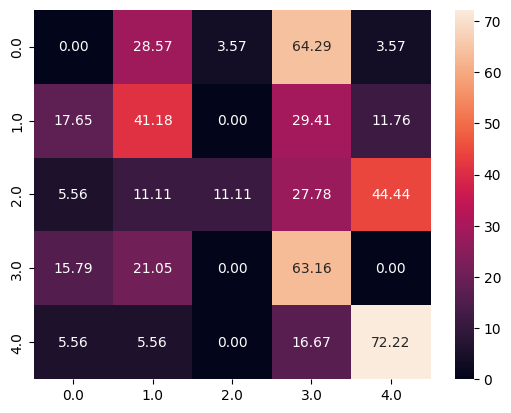

In [ ]:
print('Matrice de confusion par DTW')
cm=confusion_matrix(PartitionDTW[0],PartitionDTW[1])
cm = cm / cm.sum(axis=1, keepdims=True) * 100
sns.heatmap(data=cm,fmt='.2f',xticklabels=np.unique(LABEL_TEST),yticklabels=np.unique(LABEL_TEST),annot=True)

# score de performance
print(f'Accuracy sur base de test : {accuracy_score(PartitionDTW[0],PartitionDTW[1])*100}%')

# Partie II : Classification des battements cardiaques sur les features sans prétraitement

Réaliser une classification des battements cardiaques par une méthode d'apprentissage supervisé et une méthode d'apprentissage non supervisé de votre choix en utilisant la librairie *scikit-learn*.

Pour chaque résultat obtenu, calculer la matrice de confusion et interpréter les résultats.


## Méthodes supervisées  :
indiquer quelles sont les 2 méthodes supervisées de votre choix et calculer la matrice de confusion associée.

In [ ]:
from sklearn.metrics import confusion_matrix

# Calcul de la matrice de confusion

#confusion_matrix(y_true, y_pred)

## Méthodes non supervisées

Indiquer quelles sont les 2 méthodes non supervisées de votre choix et calculer la matrice de confusion associée.

# Partie III : classification des battements cardiaques sur les features avec prétraitement par ACP

## Méthode supervisée avec réduction de dimension par ACP sur l'ensemble d'apprentissage
Réaliser une ACP sur l'ensemble d'apprentissage pour réduire la dimension, visualiser les données
puis projeter les données de l'ensemble de test dans la base de l'ACP.

Indiquer quelles sont les 2 méthodes supervisées de votre choix et calculer la matrice de confusion associée (confusion_matrix) et le score de performance (accuracy_score)

In [ ]:
from sklearn.decomposition import PCA

In [ ]:
# Calcul de la matrice de confusion


## Méthode non supervisée avec réduction de dimension par ACP sur l'ensemble des données

Réaliser une ACP sur l'ensemble des données et indiquer quelles sont les méthodes non supervisées de votre choix et calculer la matrice de confusion associée (confusion_matrix) et le score de performance (accuracy_score)

In [ ]:
# Calcul de la matrice de confusion



# Réaliser votre étude :

- Etudier les meilleurs paramètres pour les méthodes supervisées et non supervisées que vous avez choisies.
- Faire une étude sur les paramètres issus de TSFEL en séparant par exemple les différentes modalités (statistiques,temporelles et spectrales) ou en étudiant leur correlation et essayer de réaliser des prétraitements.
- Optimiser la réduction de dimensions par ACP
